# Comparaison des distances inter-distributions
Dans ce notebook on compare selon plusieurs critères les performances entre plusieurs distances (KLD, MMD-RBF, MMD_IRQ)

In [1]:
!pip install torch torchvision
!rm -r *

    100% |████████████████████████████████| 591.8MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6087e000 @  0x7fdb323042a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 25.0MB/s 
    100% |████████████████████████████████| 2.0MB 7.1MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.


In [0]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from math import *

def KLD(var, mu):
    return .5 * (var - 1 + mu**2 - np.log(var))

In [0]:
def KL_bench(var,mu):
    KL_bench = KLD(var,mu)
    plt.plot(var,KL_bench)
    
    plt.xlabel("Variance")
    plt.ylabel("KLD")

In [0]:

# Code for MMD RBF
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = torch.exp( (tiled_x - tiled_y)**2 / (2 * float(dim)**2) )
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

def RBF_bench(var,mu,n):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    var = torch.from_numpy(var).float().squeeze(1).to(device)
    mu  = torch.from_numpy(mu).float().squeeze(0).to(device)
    
    RBF = torch.zeros([len(mu),len(var)]).to(device)
    
    for i in range(len(mu)):
        for j in range(len(var)):
            sample = torch.randn(n)*torch.sqrt(var[j]) + mu[i]
            prior  = torch.randn(n)
            RBF[i,j] = compute_mmd(sample.unsqueeze(1),prior.unsqueeze(1))
    plt.plot(var.numpy(),RBF.numpy().T)
    plt.xlabel("Variance")
    plt.ylabel("MMD RBF")
    plt.show()
    
    
    
    #########################################################################
    # Code for MMD IMQ
    
def compute_kernel_imq(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    c = 0
    kernel_input = 1 /( torch.sqrt( (tiled_x - tiled_y)**2 + c ) )
    return torch.exp(-kernel_input) # (x_size, y_size)

  
def IMQ_bench(var,mu,n):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    var = torch.from_numpy(var).float().squeeze(1).to(device)
    mu  = torch.from_numpy(mu).float().squeeze(0).to(device)
    
    IMQ = torch.zeros([len(mu),len(var)]).to(device)
    
    for i in range(len(mu)):
        for j in range(len(var)):
            sample = torch.randn(n)*torch.sqrt(var[j]) + mu[i]
            prior  = torch.randn(n)
            IMQ[i,j] = compute_mmd(sample.unsqueeze(1),prior.unsqueeze(1))
    plt.plot(var.numpy(),IMQ.numpy().T)
    plt.xlabel("Variance")
    plt.ylabel("MMD IMQ")
    plt.show()
    


In [0]:
mu = np.linspace(0,10,6).reshape(1,6)
var = np.linspace(.1,15,100).reshape(100,1)

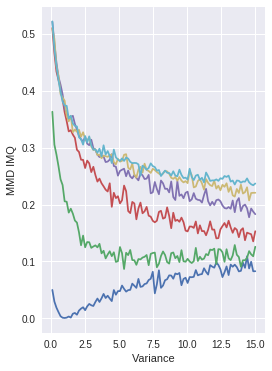

<Figure size 576x396 with 0 Axes>

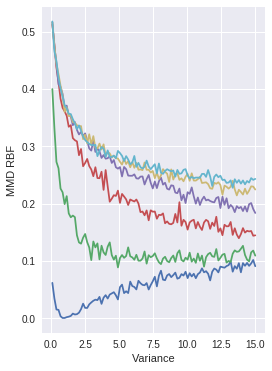

'\nplt.figure(figsize=(long,larg))\nplt.plot\nKL_bench(var,mu)\nplt.savefig("KLD_benchmark.eps")\n'

<Figure size 576x396 with 0 Axes>

In [81]:
long = 4 
larg = 6

plt.figure(figsize=(long,larg))
plt.plot
IMQ_bench(var,mu,500)
plt.savefig("MMD_IMQ_benchmark.eps")

plt.figure(figsize=(long,larg))
plt.plot  
RBF_bench(var,mu,500)
plt.savefig("MMD_RBF_benchmark.eps")

plt.figure(figsize=(long,larg))
plt.plot
KL_bench(var,mu)
plt.savefig("KLD_benchmark.eps")

"Plots were maid for (var,mu,4000)"